In [1]:
import SimpleITK as sitk  # For loading the dataset
import numpy as np  # For data manipulation
from model import build_model  # For creating the model
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import zoom
import cv2
import keras.backend as K
from keras.utils import Sequence
from keras.callbacks.callbacks import LambdaCallback

Using TensorFlow backend.


In [2]:
class GenerateData(Sequence):
    def __init__(self, data, input_shape, output_channels, batch_size):
        self.data = data
        self.input_shape = input_shape
        self.output_channels = output_channels
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        imgs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        data_x = np.empty((self.batch_size,) + self.input_shape, dtype=np.float32)
        labels = np.empty((self.batch_size, self.output_channels) + self.input_shape[1:], dtype=np.uint8)

        for index, img in enumerate(imgs):
            data_x[index] = np.array([preprocess(read_img(img[m]), self.input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
            labels[index] = preprocess_label(read_img(img['seg']), self.input_shape[1:])[None, ...]
        
        # batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        # batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        # print("X shape",data_x.shape)
        # print("Y shape",labels.shape)
        return data_x, labels
    
val_samples = [{'t1': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t1.nii.gz', 't2': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t2.nii.gz', 't1ce': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_flair.nii.gz', 'seg': 'HGG/Brats18_CBICA_AMH_1/Brats18_CBICA_AMH_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_t1.nii.gz', 't2': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_t2.nii.gz', 't1ce': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_flair.nii.gz', 'seg': 'HGG/Brats18_CBICA_ASV_1/Brats18_CBICA_ASV_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA02_377_1/Brats18_TCIA02_377_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1.nii.gz', 't2': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t2.nii.gz', 't1ce': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_flair.nii.gz', 'seg': 'HGG/Brats18_CBICA_ATD_1/Brats18_CBICA_ATD_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA02_374_1/Brats18_TCIA02_374_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA03_133_1/Brats18_TCIA03_133_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA03_265_1/Brats18_TCIA03_265_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_t1.nii.gz', 't2': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_t2.nii.gz', 't1ce': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_flair.nii.gz', 'seg': 'HGG/Brats18_TCIA02_394_1/Brats18_TCIA02_394_1_seg.nii.gz'}, {'t1': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1.nii.gz', 't2': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t2.nii.gz', 't1ce': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1ce.nii.gz', 'flair': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_flair.nii.gz', 'seg': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_seg.nii.gz'}]

In [3]:
def read_img(img_path):
    """
    Reads a .nii.gz image and returns as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))


def resize(img, shape, mode='constant', orig_shape=(155, 240, 240)):
    """
    Wrapper for scipy.ndimage.zoom suited for MRI images.
    """
    assert len(shape) == 3, "Can not have more than 3 dimensions"
    factors = (
        shape[0]/orig_shape[0],
        shape[1]/orig_shape[1], 
        shape[2]/orig_shape[2]
    )
    
    # Resize to the given shape
    return zoom(img, factors, mode=mode)


def preprocess(img, out_shape=None):
    """
    Preprocess the image.
    Just an example, you can add more preprocessing steps if you wish to.
    """
    if out_shape is not None:
        img = resize(img, out_shape, mode='constant')
    
    # Normalize the image
    mean = img.mean()
    std = img.std()
    return (img - mean) / std


def preprocess_label(img, out_shape=None, mode='nearest'):
    """
    Separates out the 3 labels from the segmentation provided, namely:
    GD-enhancing tumor (ET ? label 4), the peritumoral edema (ED ? label 2))
    and the necrotic and non-enhancing tumor core (NCR/NET ? label 1)
    """
    # print(img.shape)
    # print(np.unique(img))
    ncr = img == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
    ed = img == 2  # Peritumoral Edema (ED)
    et = img == 4  # GD-enhancing Tumor (ET)
    
    if out_shape is not None:
        ncr = resize(ncr, out_shape, mode=mode)
        ed = resize(ed, out_shape, mode=mode)
        et = resize(et, out_shape, mode=mode)

    return np.array([ncr, ed, et], dtype=np.uint8)

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    return (2. * intersection) / (
        K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + 1e-8)

In [4]:
input_shape = (4, 96, 112, 112)
# input_shape = (4, 155, 240, 240)
output_channels = 3
model = build_model(input_shape=input_shape, output_channels=3)
model.load_weights('weights/weights.epoch_100-loss_-0.14610-dice_0.64230-val_dice_0.58464.hdf5')

# sample = {'t1': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1.nii.gz',
#            't2': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t2.nii.gz',
#            't1ce': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_t1ce.nii.gz',
#            'flair': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_flair.nii.gz',
#            'seg': 'HGG/Brats18_TCIA01_460_1/Brats18_TCIA01_460_1_seg.nii.gz'}

# sample = {
#     'flair': 'LGG/Brats18_2013_0_1/Brats18_2013_0_1_flair.nii.gz',
#     't1': 'LGG/Brats18_2013_0_1/Brats18_2013_0_1_t1.nii.gz',
#     't2': 'LGG/Brats18_2013_0_1/Brats18_2013_0_1_t2.nii.gz',
#     't1ce': 'LGG/Brats18_2013_0_1/Brats18_2013_0_1_t1ce.nii.gz',
#     'seg': 'LGG/Brats18_2013_0_1/Brats18_2013_0_1_seg.nii.gz',
# }

sample = {'t1': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1.nii.gz', 
           't2': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t2.nii.gz', 
           't1ce': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_t1ce.nii.gz', 
           'flair': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_flair.nii.gz', 
           'seg': 'HGG/Brats18_2013_21_1/Brats18_2013_21_1_seg.nii.gz'}

data_x = np.empty((1,) + input_shape, dtype=np.float32)
labels = np.empty((1, output_channels) + input_shape[1:], dtype=np.uint8)
labels_original = np.empty((1, output_channels) + (96, 240, 240), dtype=np.uint8)

data_x[0] = np.array([preprocess(read_img(sample[m]), input_shape[1:]) for m in ['t1', 't2', 't1ce', 'flair']], dtype=np.float32)
labels[0] = preprocess_label(read_img(sample['seg']), input_shape[1:])[None, ...]
labels_original[0] = preprocess_label(read_img(sample['seg']), (96, 240, 240))[None, ...]

W0206 23:56:52.564548 140512858228480 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


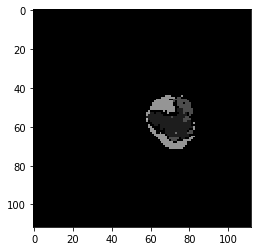

In [15]:
preds = model.predict(data_x)[0]
# scores = []

# for i in range(96):
#     pred = preds[:, i,:,:]
#     pred = np.transpose(pred, (1, 2, 0))
#     pred = np.rint(pred)
#     img = labels[0,:, i,:,:]
#     img = np.transpose(img, (1, 2, 0))
#     dice = np.sum(pred[img==1])*2.0 / (np.sum(pred) + np.sum(img))
#     if np.isnan(dice) == False:
#         scores.append(dice)

# print(scores)
# print("dice_score: %s", np.average(scores))
slice_no = 55
pred = preds[:, slice_no,:,:]
pred = np.transpose(pred, (1, 2, 0))
pred = np.rint(pred)
pred = pred*255
gray1 = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
gray1 = gray1.astype(np.uint8)
plt.imshow(gray1, cmap='gray', vmin=0, vmax=255)
# cv2.imwrite('out.png', gray1)

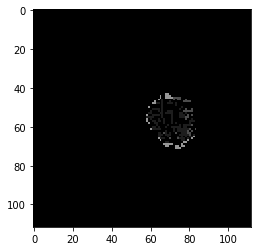

In [16]:
img = labels[0,:, slice_no,:,:]
img = np.transpose(img, (1, 2, 0))
img = img*255
gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray2, cmap='gray', vmin=0, vmax=255)
# cv2.imwrite('inp.png', gray2)

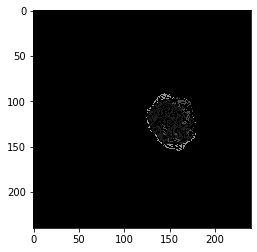

In [17]:
img = labels_original[0,:,slice_no,:,:]
img = np.transpose(img, (1, 2, 0))
img = img*255 
gray3 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray3, cmap='gray', vmin=0, vmax=255)

In [8]:
# model.evaluate(data_x, labels)
# batch_print_callback = LambdaCallback(
#     on_epoch_end=lambda epoch,logs: print(epoch, logs))
# val_gen = GenerateData(val_samples, input_shape, output_channels, 1)
# scores = model.evaluate_generator(val_gen, callbacks=[batch_print_callback],verbose=1)